In [25]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 68.6 MB 37.2 MB/s eta 0:00:01
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached fsspec-2025.5.1-py3-none-any.whl (199 kB)
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 9.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import WeightedRandomSampler

df = pd.read_csv("aaf_age_labels.csv")  # image_path, age

# 🔧 반드시 리셋
df_train = df_train.reset_index(drop=True)

# ✅ 나이 bin 지정
bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]
df_train['age_bin'] = pd.cut(df_train['age'], bins=bins, labels=False)

# ✅ bin별 샘플 수 계산
bin_counts = df_train['age_bin'].value_counts().to_dict()

# ✅ inverse 빈도 기반 가중치 생성
weights = df_train['age_bin'].apply(lambda x: 1.0 / np.log1p(bin_counts.get(x, 1))).values

# ✅ Weighted sampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


NameError: name 'df_train' is not defined

In [12]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)


✅ Device: cpu


In [257]:
df = pd.read_csv("aaf_age_labels.csv")

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Train size: {len(df_train)}, Test size: {len(df_test)}")


Train size: 10657, Test size: 2665


In [258]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [259]:
class AgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['image_path']
        age = self.df.iloc[idx]['age']
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor([age], dtype=torch.float32)


In [260]:
BATCH_SIZE = 8

train_dataset = AgeDataset(df_train, transform=train_transform)
test_dataset = AgeDataset(df_test, transform=test_transform)

# ✅ sampler 적용, shuffle 제거
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [261]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # 회귀 출력
model = model.to(device)


/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [264]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

EPOCHS = 5


In [265]:
for epoch in range(EPOCHS):
    # 🔁 학습
    model.train()
    train_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # 🧪 평가 (Test Loss + MAE)
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, targets in test_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * imgs.size(0)

            # MAE 계산용
            # MAE 계산용
            
            all_preds.extend(outputs.view(-1).cpu().numpy())
            all_targets.extend(targets.view(-1).cpu().numpy())


    avg_test_loss = test_loss / len(test_loader.dataset)
    mae_score = mean_absolute_error(all_targets, all_preds)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} / Test Loss = {avg_test_loss:.4f} / MAE = {mae_score:.2f}세")


[Train] Epoch 1: 100%|██████████| 1333/1333 [10:52<00:00,  2.04it/s]


Epoch 1: Train Loss = 334.2270 / Test Loss = 84.7497 / MAE = 7.20세


[Train] Epoch 2: 100%|██████████| 1333/1333 [10:53<00:00,  2.04it/s]


Epoch 2: Train Loss = 75.1903 / Test Loss = 71.4989 / MAE = 6.57세


[Train] Epoch 3: 100%|██████████| 1333/1333 [10:54<00:00,  2.04it/s]


Epoch 3: Train Loss = 50.4819 / Test Loss = 64.5434 / MAE = 6.27세


[Train] Epoch 4: 100%|██████████| 1333/1333 [10:53<00:00,  2.04it/s]


Epoch 4: Train Loss = 41.6519 / Test Loss = 56.5670 / MAE = 5.65세


[Train] Epoch 5: 100%|██████████| 1333/1333 [10:47<00:00,  2.06it/s]


Epoch 5: Train Loss = 36.0760 / Test Loss = 60.8826 / MAE = 5.99세


In [5]:
# ✅ 학습 끝난 모델 저장 (Jupyter에서 다음 셀에서 실행해도 OK)
torch.save(model.state_dict(), "final_model.pth")
print("✅ 최종 모델이 저장되었습니다: final_model.pth")

✅ 최종 모델이 저장되었습니다: final_model.pth


In [6]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        output.backward()  # 회귀 → scalar backward

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1)).squeeze()

        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [7]:
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor, np.array(img)  # ✅ numpy image 반환

def show_gradcam_on_image(img, mask, alpha=0.5):
    # ✅ Step 1: 원본 이미지 크기 조정
    img_resized = cv2.resize(img, (224, 224))

    # ✅ Step 2: 이미지 dtype 확인 및 보정 (정수형 필요)
    if img_resized.dtype != np.uint8:
        img_resized = np.clip(img_resized, 0, 255).astype(np.uint8)

    # ✅ Step 3: heatmap 생성 및 컬러 맵 적용
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # ✅ Step 4: overlay
    overlay = heatmap * alpha + img_resized * (1 - alpha)
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    # ✅ Step 5: 시각화
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()



In [8]:
import pandas as pd

# 1. CSV 로드
df = pd.read_csv("aaf_age_labels.csv")

# 2. 예시 이미지 선택
row = df.sample(1).iloc[0]  # 무작위 한 장
image_path = row["image_path"]
true_age = row["age"]

print(f"🖼️ 선택된 이미지: {image_path} (실제 나이: {true_age}세)")


🖼️ 선택된 이미지: /Users/geko/COSE471_data-science/AFF/aglined_faces/02146A25.jpg (실제 나이: 25세)


/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/geko/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


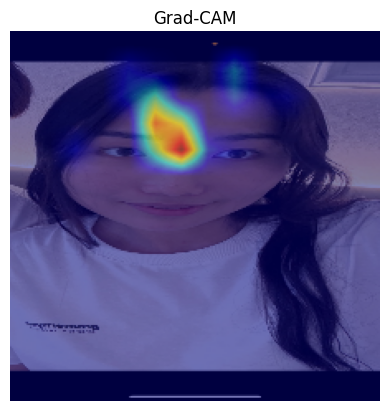

예측된 나이: 24.60세


In [14]:
import torch
from torchvision import models
import torch.nn as nn

# 모델 정의와 가중치 로드
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("final_model.pth", map_location=torch.device("cpu")))
model.eval()

# Grad-CAM 객체 생성 (layer3 블록)
target_layer = model.layer3[-1]
cam = GradCAM(model, target_layer)

# 이미지 불러오기 및 전처리
image_path = "/Users/geko/COSE471_data-science/IMG_2550.JPG"  # 분석할 이미지 경로
input_tensor, original_img = preprocess_image(image_path)

# Grad-CAM 생성
cam_map = cam.generate(input_tensor.to(device))

# 결과 시각화
show_gradcam_on_image(original_img, cam_map)

# 예측 나이 출력
with torch.no_grad():
    pred = model(input_tensor.to(device)).item()
print(f"예측된 나이: {pred:.2f}세")



In [362]:
def create_region_masks(image_size=(224, 224)):
    masks = {}

    eye_mask = np.zeros(image_size, dtype=np.uint8)
    cv2.rectangle(eye_mask, (60, 70), (100, 100), 1, -1)  # 왼쪽 눈
    cv2.rectangle(eye_mask, (124, 70), (164, 100), 1, -1)  # 오른쪽 눈
    masks['eye'] = eye_mask

    forehead_mask = np.zeros(image_size, dtype=np.uint8)
    cv2.rectangle(forehead_mask, (70, 30), (154, 65), 1, -1)
    masks['forehead'] = forehead_mask

    mouth_mask = np.zeros(image_size, dtype=np.uint8)
    cv2.rectangle(mouth_mask, (85, 140), (140, 170), 1, -1)
    masks['mouth'] = mouth_mask

    return masks


In [363]:
def analyze_attention(cam_mask, region_masks):
    scores = {}
    for region, mask in region_masks.items():
        region_area = cam_mask[mask.astype(bool)]
        scores[region] = float(region_area.mean()) if region_area.size > 0 else 0.0
    return scores


In [364]:
cam_map = cam.generate(input_tensor.to(device))  # 224x224 np.float32 mask
region_masks = create_region_masks()
attention_scores = analyze_attention(cam_map, region_masks)

print(attention_scores)
# 예시 출력: {'eye': 0.58, 'forehead': 0.22, 'mouth': 0.36}


{'eye': 0.050206441432237625, 'forehead': 0.0, 'mouth': 0.0}


In [10]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18 기반 회귀 모델 정의
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 1)  # 회귀용 출력
model = model.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load("final_model.pth", map_location=device))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [283]:
import numpy as np

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        outputs = model(imgs)
        all_preds.extend(outputs.view(-1).cpu().numpy())
        all_targets.extend(targets.view(-1).cpu().numpy())


In [284]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# 결과 DataFrame 생성
df_result = pd.DataFrame({
    'true_age': all_targets,
    'pred_age': all_preds,
})

# 나이 bin 설정
bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-100']
df_result['age_group'] = pd.cut(df_result['true_age'], bins=bins, labels=labels)

# 그룹별 MAE 출력
for group in labels:
    group_data = df_result[df_result['age_group'] == group]
    if len(group_data) > 0:
        mae = mean_absolute_error(group_data['true_age'], group_data['pred_age'])
        print(f"[{group}] MAE = {mae:.2f}세 (n={len(group_data)})")


[0-10] MAE = 2.48세 (n=223)
[11-20] MAE = 4.92세 (n=263)
[21-30] MAE = 4.16세 (n=666)
[31-40] MAE = 6.30세 (n=652)
[41-50] MAE = 8.23세 (n=401)
[51-60] MAE = 9.08세 (n=209)
[61-70] MAE = 8.95세 (n=151)
[71-100] MAE = 7.04세 (n=100)
